# 모듈 import

In [1]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor,plot_importance
from scipy.stats import f_oneway
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# gpu

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

# 데이터 전처리

In [29]:

past_sales = pd.read_csv('C:/Users/PC/표/수요예측/rossmann-store-sales/train.csv')
store = pd.read_csv('C:/Users/PC/표/수요예측/rossmann-store-sales/store.csv')

past_sales['Date'] = pd.to_datetime(past_sales['Date'], format="%Y-%m-%d") # 년도, 달, 일 순으로 format
# a = 공휴일, b = 부활절 공휴일, c = 크리스마스, d = 없음
past_sales['StateHoliday'] = past_sales['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
past_sales['StateHoliday'] = past_sales['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체
past_sales = past_sales.sort_values('Date') # date 기준으로 정렬

store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)

# 결측값 확인 : past_sales.isnull().sum(), store_a.isnull().sum()
# store의 CompetitionDistance에 3개 있음
# 결측값 : 평균으로 대체
store['CompetitionDistance'] = store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean())

# 병합
data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')
data['Month']=pd.DatetimeIndex(data.Date).month
data['Day']=pd.DatetimeIndex(data.Date).day
data = data.drop(['Date'],axis=1) # 그래프 그릴려고 잠시 제거한 코드

data = data[data['Store'] == 1022]
data = data.drop(['Store'], axis=1)
data = data.drop(['StoreType'], axis=1)
data = data.drop(['Assortment'], axis=1)
pd.options.display.max_columns = None


C:\Users\PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# 평균값인코딩

In [30]:
# StoreType_mean = data.groupby("StoreType")["Sales"].mean()
# data.loc[data['StoreType'] == 'a', 'StoreType'] = StoreType_mean[0]
# # data.loc[data['StoreType'] == 'b', 'StoreType'] = StoreType_mean[1]
# data.loc[data['StoreType'] == 'c', 'StoreType'] = StoreType_mean[2]
# data.loc[data['StoreType'] == 'd', 'StoreType'] = StoreType_mean[3]

StateHoliday_mean = data.groupby("StateHoliday")["Sales"].mean()
data.loc[data['StateHoliday'] == 'a', 'StateHoliday'] = StateHoliday_mean[0]
data.loc[data['StateHoliday'] == 'b', 'StateHoliday'] = StateHoliday_mean[1]
data.loc[data['StateHoliday'] == 'c', 'StateHoliday'] = StateHoliday_mean[2]
data.loc[data['StateHoliday'] == 'd', 'StateHoliday'] = StateHoliday_mean[3]

# Assortment_mean = data.groupby("Assortment")["Sales"].mean()
# data.loc[data['Assortment'] == 'a', 'Assortment'] = Assortment_mean[0]
# data.loc[data['Assortment'] == 'b', 'Assortment'] = Assortment_mean[1]
# data.loc[data['Assortment'] == 'c', 'Assortment'] = Assortment_mean[2]

In [31]:
data

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,Promo2,Month,Day
931237,2,0,0,0,0,0,1,1520.0,0,1,1
931238,3,5584,697,1,0,6249.92,1,1520.0,0,1,2
931239,4,4971,630,1,0,6249.92,1,1520.0,0,1,3
931240,5,5123,649,1,0,6249.92,1,1520.0,0,1,4
931241,6,5961,704,1,0,6249.92,0,1520.0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...
932174,1,10117,937,1,1,6249.92,1,1520.0,0,7,27
932175,2,8038,785,1,1,6249.92,1,1520.0,0,7,28
932176,3,6750,710,1,1,6249.92,1,1520.0,0,7,29
932177,4,8021,823,1,1,6249.92,1,1520.0,0,7,30


# 표준화

In [43]:
scaler = StandardScaler().fit(data)
data = pd.DataFrame(scaler.transform(data),index = data.index, columns = data.columns)

# windows_size

In [44]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)        
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
# features = features.values
# target = target.values

features_copy = []
target_copy = []

windows_size = 5
for i in range(len(features)-windows_size) :
    features_copy.append(np.array(features.iloc[i:i+windows_size]))
    target_copy.append(np.array(target.iloc[i:i+windows_size]))

In [45]:
np.array(target_copy).shape

(937, 5, 1)

# train_test_split

In [46]:
x_train, x_test, y_train, y_test = train_test_split(features_copy, target_copy, test_size=0.4)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5)

In [47]:
np.array(y_test).shape

(187, 5, 1)

In [48]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_valid = np.array(x_valid)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_valid = np.array(y_valid)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_valid = x_valid.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
y_valid = y_valid.astype(np.float32)





In [49]:
print('train_data의 row : %s, column : %s'%(x_train.shape[0],x_train.shape[1]))
print('test_data의 row : %s, column : %s'%(x_test.shape[0],x_test.shape[1]))
print('val_data의 row : %s, column : %s'%(x_valid.shape[0],x_valid.shape[1]))

train_data의 row : 562, column : 5
test_data의 row : 187, column : 5
val_data의 row : 188, column : 5


In [50]:
np.array(x_train).shape

(562, 5, 10)

# 학습

In [51]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32,input_shape=(3,10),return_sequences=True))
model.add(tf.keras.layers.LSTM(32,return_sequences=True))
model.add(tf.keras.layers.LSTM(16,return_sequences=False))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 3, 32)             5504      
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 32)             8320      
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 17,249
Trainable params: 17,249
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(loss='mse',
             optimizer='adam',
             metrics=['mae'])

In [53]:
history = model.fit(x_train,y_train,
                   validation_data = (x_valid,y_valid),
                   batch_size = 5,
                   epochs = 50)

Epoch 1/50
113/113 [==============================] - 4s 39ms/step - loss: 0.9343 - mae: 0.6919 - val_loss: 0.8293 - val_mae: 0.6430
Epoch 2/50
113/113 [==============================] - 3s 27ms/step - loss: 0.8654 - mae: 0.6699 - val_loss: 0.8033 - val_mae: 0.6586
Epoch 3/50
113/113 [==============================] - 3s 28ms/step - loss: 0.8514 - mae: 0.6689 - val_loss: 0.7881 - val_mae: 0.6384
Epoch 4/50
113/113 [==============================] - 3s 26ms/step - loss: 0.8460 - mae: 0.6666 - val_loss: 0.7845 - val_mae: 0.6271
Epoch 5/50
113/113 [==============================] - 3s 27ms/step - loss: 0.8425 - mae: 0.6636 - val_loss: 0.7837 - val_mae: 0.6406
Epoch 6/50
113/113 [==============================] - 3s 27ms/step - loss: 0.8421 - mae: 0.6647 - val_loss: 0.7808 - val_mae: 0.6272
Epoch 7/50
113/113 [==============================] - 3s 26ms/step - loss: 0.8387 - mae: 0.6647 - val_loss: 0.7785 - val_mae: 0.6341
Epoch 8/50
113/113 [==============================] - 3s 27ms/step - 

# 평가

In [54]:
y_train1 = target[:len(x_train)]
y_test1 = target[len(x_train):len(x_train)+len(x_test)]
y_valid1 = target[len(x_train)+len(x_test):len(target)-windows_size]

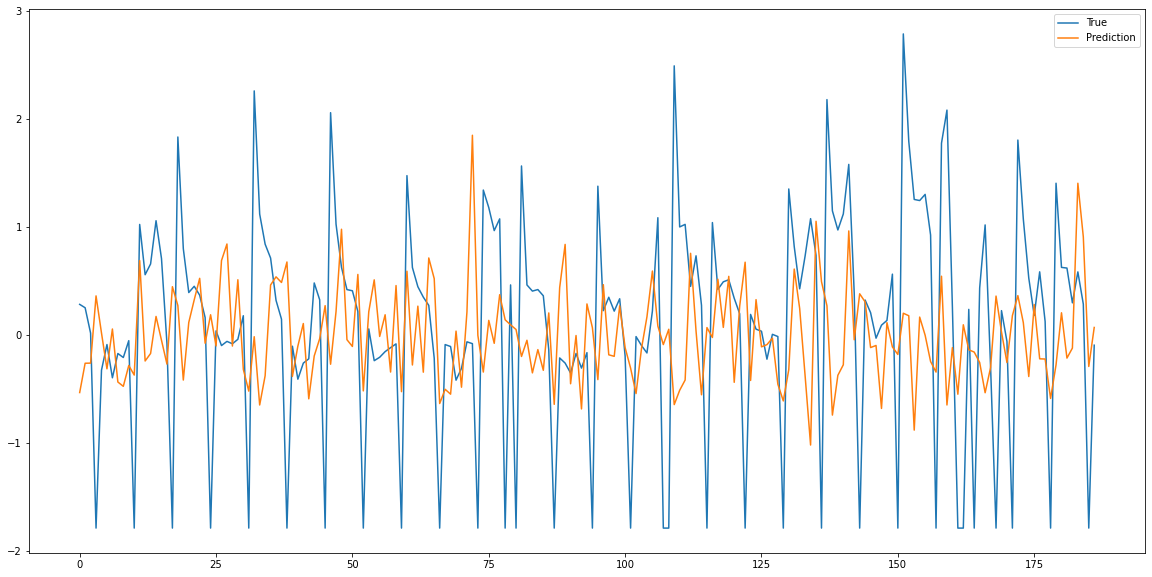

In [55]:
pred = model.predict(x_test)
y_test1 = y_test1.values.tolist()
y_test1 = np.array(y_test1)
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test1, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

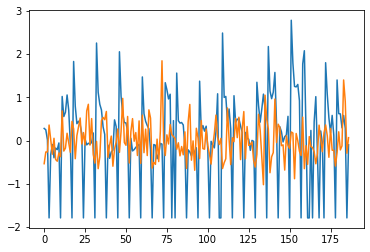

In [56]:
pred_365 = pred[0:365]
y_test1_365 = y_test1[0:365]

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test1_365, label='True')
ax.plot(pred_365, label='Prediction')

In [61]:
from sklearn.metrics import r2_score
pred = model.predict(x_test)
r2 = r2_score(y_test1,pred)
print(r2)

-0.1666400954722378


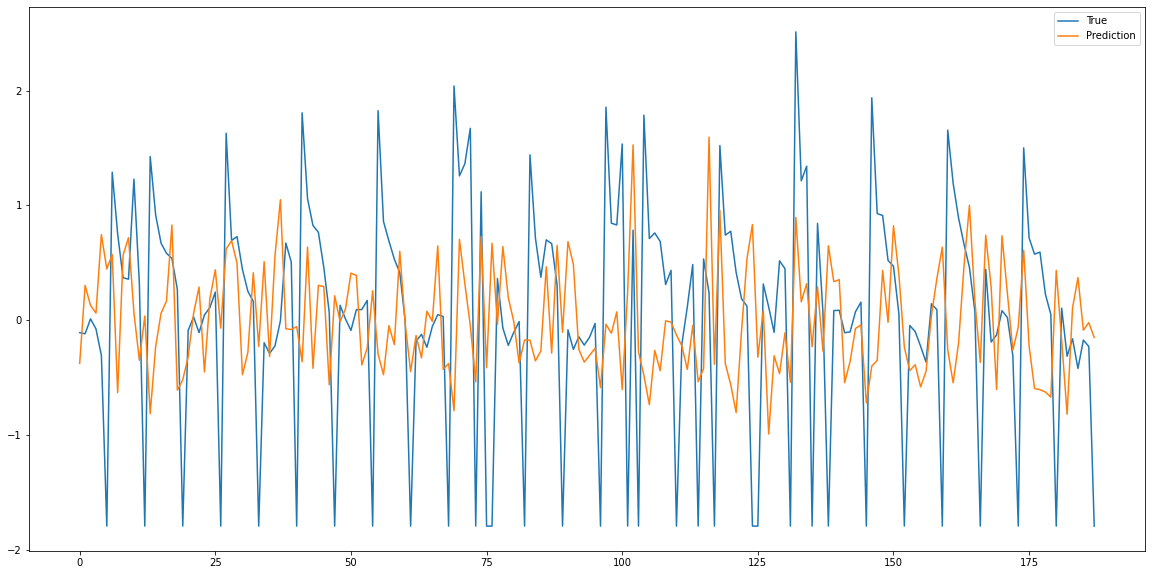

In [58]:
pred_valid = model.predict(x_valid)
y_valid1 = y_valid1.values.tolist()
y_valid1 = np.array(y_valid1)
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_valid1, label='True')
ax.plot(pred_valid, label='Prediction')
ax.legend()
plt.show()

In [59]:
from sklearn.metrics import r2_score
r2 = r2_score(y_valid1, pred_valid)
print(r2)

-0.1444900098170807
